In [ ]:
## 1. Transform data to record format
## First dataset from http://www.robots.ox.ac.uk/~vgg/data/scenetext/
## This method failed, because 

In [1]:
%matplotlib inline
import math
import numpy as np
import scipy.io as sio
import gzip
from zipfile import ZipFile
import matplotlib.pyplot as plt
import cv2
import sys
sys.path.insert(0,'../')
sys.path.insert(0,'../processing/')
from datasets import sythtextprovider
import tensorflow as tf
import skimage.io as skio
#tf.InteractiveSession()
from PIL import Image
import re
import os
slim = tf.contrib.slim
tf.__version__
#from image_processing2 import *
from processing import ssd_vgg_preprocessing
import tf_extended as tfe
from processing import tf_image
from nets import txtbox_300
import tf_utils
from nets import custom_layers

In [7]:
syntext = sio.loadmat('../data/sythtext/gt.mat')
syntext.keys()

['wordBB',
 'txt',
 '__header__',
 '__globals__',
 '__version__',
 'imnames',
 'charBB']

In [18]:
wordBB = syntext['wordBB']
imnames = syntext['imnames']
txt = syntext['txt']
print imnames[0,10][0]
index = 10
img = cv2.imread(imnames[0,index][0])
bbox = wordBB[0,index]
text = txt[0,index]

8/ballet_106_107.jpg


In [23]:
print bbox[:,:,0]
np.min(bbox[:,:,0],1)

[[ 418.89144897  466.56863403  464.68301392  417.00582886]
 [ 230.17230225  233.0020752   264.77197266  261.94219971]]


array([ 417.00582886,  230.17230225], dtype=float32)

In [2]:
def int64_feature(value):
    """Wrapper for inserting int64 features into Example proto.
    """
    if not isinstance(value, list):
        value = [value]
    return tf.train.Feature(int64_list=tf.train.Int64List(value=value))


def float_feature(value):
    """Wrapper for inserting float features into Example proto.
    """
    if not isinstance(value, list):
        value = [value]
    return tf.train.Feature(float_list=tf.train.FloatList(value=value))


def bytes_feature(value):
    """Wrapper for inserting bytes features into Example proto.
    """
    if not isinstance(value, list):
        value = [value]
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=value))

In [3]:
def visualize_bbox(image, bboxes):
    """
    Input: image (height, width, channels)
           bboxes (numof bboxes, 4) in order(ymin, xmin, ymax, xmax)
                  range(0,1) 
    """
    numofbox = bboxes.shape[0]
    width = image.shape[1]
    height = image.shape[0]
    def norm(x):
        if x < 0:
            x = 0
        else:
            if x > 1:
                x = 1
        return x
    xmin = [int(i * width) for i in bboxes[:,1]]
    ymin = [int(i * height) for i in bboxes[:,0]]
    ymax = [int(i * height) for i in bboxes[:,2]]
    xmax = [int(i * width) for i in bboxes[:,3]]

    for i in range(numofbox):
        image = cv2.rectangle(image,(xmin[i],ymin[i]),
                             (xmax[i],ymax[i]),(0,255,255))
    print [ymin,xmin,ymax,xmax]
    skio.imshow(image)
    skio.show()

In [13]:
_R_MEAN = 123.
_G_MEAN = 117.
_B_MEAN = 104.

# Some training pre-processing parameters.
BBOX_CROP_OVERLAP = 0.4        # Minimum overlap to keep a bbox after cropping.
CROP_RATIO_RANGE = (0.8, 1.2)  # Distortion ratio during cropping.
EVAL_SIZE = (300, 300)
def tf_image_whitened(image, means=[_R_MEAN, _G_MEAN, _B_MEAN]):
    """Subtracts the given means from each image channel.

    Returns:
        the centered image.
    """
    if image.get_shape().ndims != 3:
        raise ValueError('Input must be of size [height, width, C>0]')
    num_channels = image.get_shape().as_list()[-1]
    if len(means) != num_channels:
        raise ValueError('len(means) must match the number of channels')

    mean = tf.constant(means, dtype=image.dtype)
    image = image - mean
    return image


def tf_image_unwhitened(image, means=[_R_MEAN, _G_MEAN, _B_MEAN], to_int=True):
    """Re-convert to original image distribution, and convert to int if
    necessary.

    Returns:
      Centered image.
    """
    mean = tf.constant(means, dtype=image.dtype)
    image = image + mean
    if to_int:
        image = tf.cast(image, tf.int32)
    return image


def np_image_unwhitened(image, means=[_R_MEAN, _G_MEAN, _B_MEAN], to_int=True):
    """Re-convert to original image distribution, and convert to int if
    necessary. Numpy version.

    Returns:
      Centered image.
    """
    img = np.copy(image)
    img += np.array(means, dtype=img.dtype)
    if to_int:
        img = img.astype(np.uint8)
    return img

In [4]:
def distort_color(image, scope=None):
    """Distort the color of the image.

    Each color distortion is non-commutative and thus ordering of the color ops
    matters. Ideally we would randomly permute the ordering of the color ops.
    Rather then adding that level of complication, we select a distinct ordering
    of color ops for each preprocessing thread.

    Args:
    image: Tensor containing single image.
    thread_id: preprocessing thread ID.
    scope: Optional scope for op_scope.
    Returns:
    color-distorted image
    """
    with tf.name_scope( scope, 'distort_color',[image]):
        color_ordering = np.random.randint(2)

        if color_ordering == 0:
          image = tf.image.random_brightness(image, max_delta=32. / 255.)
          image = tf.image.random_saturation(image, lower=0.5, upper=1.5)
          image = tf.image.random_hue(image, max_delta=0.2)
          image = tf.image.random_contrast(image, lower=0.5, upper=1.5)
        elif color_ordering == 1:
          image = tf.image.random_brightness(image, max_delta=32. / 255.)
          image = tf.image.random_contrast(image, lower=0.5, upper=1.5)
          image = tf.image.random_saturation(image, lower=0.5, upper=1.5)
          image = tf.image.random_hue(image, max_delta=0.2)

        # The random_* ops do not necessarily clamp.
        image = tf.clip_by_value(image, 0.0, 1.0)
        return image

text_shape (300, 300)
file_path: ../data/sythtext/*.tfrecord
(38, 38, 2, 1)
(6,)
(?, 4)
(19, 19, 2, 1)
(6,)
(?, 4)
(10, 10, 2, 1)
(6,)
(?, 4)
(5, 5, 2, 1)
(6,)
(?, 4)
(3, 3, 2, 1)
(6,)
(?, 4)
(1, 1, 2, 1)
(6,)
(?, 4)
2
[[-0.04577282  0.31835979  0.05012445  0.62201673]
 [ 0.36279464  0.82131755  0.53512722  1.0130043 ]]
(300, 300, 3)
[[-13, 108], [95, 246], [15, 160], [186, 303]]


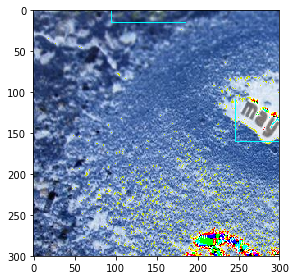

(38, 38, 2, 1)
(38, 38, 2, 6, 4)


In [38]:
with tf.Graph().as_default(): 
    # build a net
    text_net = txtbox_300.TextboxNet()
    text_shape = text_net.params.img_shape
    print 'text_shape '+  str(text_shape)
    text_anchors = text_net.anchors(text_shape)
    
    ## dataset provider
    dataset = sythtextprovider.get_datasets('../data/sythtext/')
    
    data_provider = slim.dataset_data_provider.DatasetDataProvider(
            dataset, common_queue_capacity=32, common_queue_min=2)
    
    [image, shape, glabels, gbboxes,height,width] = \
    data_provider.get(['image', 'shape',
                     'object/label',
                     'object/bbox','height','width'])
    
    bbox_begin, bbox_size, distort_bbox = tf.image.sample_distorted_bounding_box(
                    tf.shape(image),
                    bounding_boxes=tf.expand_dims(gbboxes, 0),
                    min_object_covered=0.1,
                    aspect_ratio_range=(0.9,1.1),
                    area_range=(0.1,1.0),
                    max_attempts=200,
                    use_image_if_no_bounding_boxes=True)
    
    distort_bbox = distort_bbox[0, 0]

    # Crop the image to the specified bounding box.
    cropped_image = tf.slice(image, bbox_begin, bbox_size)
    bboxes = tfe.bboxes_resize(distort_bbox, gbboxes)
    labels, bboxes, num = tfe.bboxes_filter_overlap(glabels, bboxes, 0.5)
    cropped_image ,bboxes = tf_image.resize_image_bboxes_with_crop_or_pad(cropped_image, bboxes,300,300)
    dst_image, bboxes = tf_image.random_flip_left_right(cropped_image, bboxes)
    dst_image = tf.cast(dst_image,tf.float32)
    dst_image.set_shape([300, 300, 3])
    #dst_image = distort_color(dst_image)
    # why take distort_color
    
    # groud truth
    glocalisations, gscores = \
    text_net.bboxes_encode( bboxes, text_anchors,num,match_threshold = 0.5)
    
    bbox_image = tf.image.draw_bounding_boxes(tf.expand_dims(dst_image,0), tf.expand_dims(bboxes,0))
    # batch
    batch_shape = [1] + [6] * 2
    r = tf.train.batch(
        tf_utils.reshape_list([dst_image, glocalisations, gscores]),
        batch_size=1,
        num_threads=1,
        capacity=2)
    b_image, b_glocalisations, b_gscores= \
           tf_utils.reshape_list(r, batch_shape)
     
    inputs = b_image  

    ## net predict
    localisations, logits, end_points = \
    text_net.net(b_image, is_training=True)
    
    ## loss
    
    loss = text_net.losses(logits, localisations,
           b_glocalisations, b_gscores,
           match_threshold=0.5,
           negative_ratio=3,
           alpha=1,
           label_smoothing=0)
    
    with tf.Session() as sess: 
        sess.run(tf.global_variables_initializer())
        with slim.queues.QueueRunners(sess):
            for i in xrange(1):
                image_, bbox_, num_, bbox_img= \
                sess.run([dst_image,bboxes,num,bbox_image])
                #print name
                #print height,width
                #height, width = shape[0],shape[1]
                print num_
                #print len(glabels)
                print bbox_
                print image_.shape
                image_ = np.uint8(image_)*255
                visualize_bbox(image_, bbox_)
                
                #bbox_img = sess.run(bbox_image)
                #anchors_ = sess.run([text_anchors])
                print text_anchors[0][0].shape
                
                glocalisations_, gscores_ = \
                sess.run([glocalisations, gscores])
                print glocalisations_[0].shape
                
                b_image_, b_glocalisations_, b_gscores_ = sess.run([b_image, b_glocalisations, b_gscores])
                r = sess.run(r)
                localisations_, logits_, end_points_ =\
                sess.run([localisations, logits, end_points])
                #net = sess.run([net])
                #end_points_ = sess.run([end_points])
                loss = sess.run(loss)
                #print loss

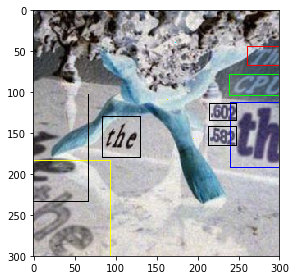

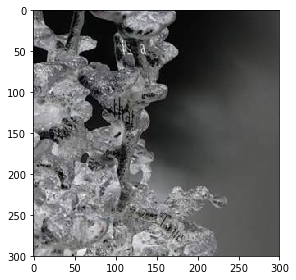

In [32]:
new_img = np_image_unwhitened(image_)
bbox_img_ =np.uint8(bbox_img[0])*255
skio.imshow(bbox_img_)
skio.show()

b_image__ =np.uint8(b_image_[0])*255
skio.imshow(b_image__)
skio.show()

In [39]:

for i in range(6):
    pmask = gscores_[0] > 0.
    print np.sum(pmask)

88
88
88
88
88
88


In [42]:
for i in range(6):
    print np.where(gscores_[i] <0.5)
np.expand_dims(image_,0).shape

(array([ 0,  0,  0, ..., 37, 37, 37]), array([ 0,  0,  0, ..., 37, 37, 37]), array([0, 0, 0, ..., 1, 1, 1]), array([0, 1, 2, ..., 3, 4, 5]))
(array([ 0,  0,  0, ..., 18, 18, 18]), array([ 0,  0,  0, ..., 18, 18, 18]), array([0, 0, 0, ..., 1, 1, 1]), array([0, 1, 2, ..., 3, 4, 5]))
(array([0, 0, 0, ..., 9, 9, 9]), array([0, 0, 0, ..., 9, 9, 9]), array([0, 0, 0, ..., 1, 1, 1]), array([0, 1, 2, ..., 3, 4, 5]))
(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2

(1, 300, 300, 3)

In [29]:
print localisations_[0].shape
print logits_[0].shape
b_gscores_[0].shape
print len(logits_)
print b_gscores_[0].shape
print b_glocalisations_[0].shape

(1, 38, 38, 2, 6, 4)
(1, 38, 38, 2, 6, 2)
6
(1, 38, 38, 2, 6)
(1, 38, 38, 2, 6, 4)


In [8]:
## achors
text_anchors[0][2]

array([ 0.2       ,  0.14142136,  0.11547005,  0.08944272,  0.0755929 ,
        0.06324555], dtype=float32)

In [43]:
loss

(133.5901, 8.3586912)